#  Standard Hypo Test Demo
Standard tutorial macro for hypothesis test (for computing the discovery significance) using all
RooStats hypotheiss tests calculators and test statistics.

Usage:

```cpp
root>.L StandardHypoTestDemo.C
root> StandardHypoTestDemo("fileName","workspace name","S+B modelconfig name","B model name","data set
name",calculator type, test statistic type, number of toys)

 type = 0 Freq calculator
 type = 1 Hybrid calculator
 type = 2 Asymptotic calculator
 type = 3 Asymptotic calculator using nominal Asimov data sets (not using fitted parameter values but nominal ones)

testStatType = 0 LEP
             = 1 Tevatron
             = 2 Profile Likelihood
             = 3 Profile Likelihood one sided (i.e. = 0 if mu_hat < 0)
```




**Author:** Lorenzo Moneta  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:28 AM.</small></i>

In [1]:
%%cpp -d
#include "TFile.h"
#include "RooWorkspace.h"
#include "RooAbsPdf.h"
#include "RooRealVar.h"
#include "RooDataSet.h"
#include "RooStats/ModelConfig.h"
#include "RooRandom.h"
#include "TGraphErrors.h"
#include "TGraphAsymmErrors.h"
#include "TCanvas.h"
#include "TLine.h"
#include "TSystem.h"
#include "TROOT.h"

#include "RooStats/AsymptoticCalculator.h"
#include "RooStats/HybridCalculator.h"
#include "RooStats/FrequentistCalculator.h"
#include "RooStats/ToyMCSampler.h"
#include "RooStats/HypoTestPlot.h"

#include "RooStats/NumEventsTestStat.h"
#include "RooStats/ProfileLikelihoodTestStat.h"
#include "RooStats/SimpleLikelihoodRatioTestStat.h"
#include "RooStats/RatioOfProfiledLikelihoodsTestStat.h"
#include "RooStats/MaxLikelihoodEstimateTestStat.h"

#include "RooStats/HypoTestInverter.h"
#include "RooStats/HypoTestInverterResult.h"
#include "RooStats/HypoTestInverterPlot.h"

#include <cassert>

In [2]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace RooFit;
using namespace RooStats;

In [3]:
struct HypoTestOptions {

   bool noSystematics = false; // force all systematics to be off (i.e. set all nuisance parameters as constat
   double nToysRatio = 4;      // ratio Ntoys Null/ntoys ALT
   double poiValue = -1;       // change poi snapshot value for S+B model (needed for expected p0 values)
   int printLevel = 0;
   bool generateBinned = false;       // for binned generation
   bool useProof = false;             // use Proof
   bool enableDetailedOutput = false; // for detailed output
};

HypoTestOptions optHT;

 Arguments are defined. 

In [4]:
const char *infile = "";
const char *workspaceName = "combined";
const char *modelSBName = "ModelConfig";
const char *modelBName = "";
const char *dataName = "obsData";
int calcType = 0;
int testStatType = 3;
int ntoys = 5000;
bool useNC = false;
const char *nuisPriorName = 0;

In [5]:
bool noSystematics = optHT.noSystematics;
double nToysRatio = optHT.nToysRatio; // ratio Ntoys Null/ntoys ALT
double poiValue = optHT.poiValue;     // change poi snapshot value for S+B model (needed for expected p0 values)
int printLevel = optHT.printLevel;
bool generateBinned = optHT.generateBinned; // for binned generation
bool useProof = optHT.useProof;             // use Proof
bool enableDetOutput = optHT.enableDetailedOutput;

Other parameter to pass in tutorial
 apart from standard for filename, ws, modelconfig and data

Type = 0 freq calculator
 type = 1 Hybrid calculator
 type = 2 Asymptotic calculator

Teststattype = 0 lep
 = 1 Tevatron
 = 2 Profile Likelihood
 = 3 Profile Likelihood one sided (i.e. = 0 if mu < mu_hat)

Ntoys:         number of toys to use

Usenumbercounting:  set to true when using number counting events

Nuispriorname:   name of prior for the nuisance. this is often expressed as constraint term in the global model
 It is needed only when using the HybridCalculator (type=1)
 If not given by default the prior pdf from ModelConfig is used.

Extra options are available as global parameters of the macro. they major ones are:

Generatebinned       generate binned data sets for toys (default is false) - be careful not to activate with
 a too large (>=3) number of observables
 nToyRatio            ratio of S+B/B toys (default is 2)
 printLevel

Disable - can cause some problems
 ToyMCSampler::SetAlwaysUseMultiGen(true);

In [6]:
SimpleLikelihoodRatioTestStat::SetAlwaysReuseNLL(true);
ProfileLikelihoodTestStat::SetAlwaysReuseNLL(true);
RatioOfProfiledLikelihoodsTestStat::SetAlwaysReuseNLL(true);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Roorandom::randomgenerator()->setseed(0);

To change minimizers
 ~~~{.bash}
 ROOT::Math::MinimizerOptions::SetDefaultStrategy(0);
 ROOT::Math::MinimizerOptions::SetDefaultMinimizer("Minuit2");
 ROOT::Math::MinimizerOptions::SetDefaultTolerance(1);
 ~~~

-------------------------------------------------------
 First part is just to access a user-defined file
 or create the standard example file if it doesn't exist

In [7]:
const char *filename = "";
if (!strcmp(infile, "")) {
   filename = "results/example_combined_GaussExample_model.root";
   bool fileExist = !gSystem->AccessPathName(filename); // note opposite return code
   // if file does not exists generate with histfactory
   if (!fileExist) {
#ifdef _WIN32
      cout << "HistFactory file cannot be generated on Windows - exit" << endl;
      return;
#endif
      // Normally this would be run on the command line
      cout << "will run standard hist2workspace example" << endl;
      gROOT->ProcessLine(".! prepareHistFactory .");
      gROOT->ProcessLine(".! hist2workspace config/example.xml");
      cout << "\n\n---------------------" << endl;
      cout << "Done creating example input" << endl;
      cout << "---------------------\n\n" << endl;
   }

} else
   filename = infile;

Try to open the file

In [8]:
TFile *file = TFile::Open(filename);

If input file was specified byt not found, quit

In [9]:
if (!file) {
   cout << "StandardRooStatsDemoMacro: Input file " << filename << " is not found" << endl;
   return;
}

-------------------------------------------------------
 Tutorial starts here
 -------------------------------------------------------

Get the workspace out of the file

In [10]:
RooWorkspace *w = (RooWorkspace *)file->Get(workspaceName);
if (!w) {
   cout << "workspace not found" << endl;
   return;
}
w->Print();


RooWorkspace(combined) combined contents

variables
---------
(Lumi,SigXsecOverSM,alpha_syst1,alpha_syst2,alpha_syst3,binWidth_obs_x_channel1_0,binWidth_obs_x_channel1_1,binWidth_obs_x_channel1_2,channelCat,gamma_stat_channel1_bin_0,gamma_stat_channel1_bin_1,nom_alpha_syst1,nom_alpha_syst2,nom_alpha_syst3,nom_gamma_stat_channel1_bin_0,nom_gamma_stat_channel1_bin_1,nominalLumi,obs_x_channel1,weightVar)

p.d.f.s
-------
RooGaussian::alpha_syst1Constraint[ x=alpha_syst1 mean=nom_alpha_syst1 sigma=1 ] = 1
RooGaussian::alpha_syst2Constraint[ x=alpha_syst2 mean=nom_alpha_syst2 sigma=1 ] = 1
RooGaussian::alpha_syst3Constraint[ x=alpha_syst3 mean=nom_alpha_syst3 sigma=1 ] = 1
RooRealSumPdf::channel1_model[ binWidth_obs_x_channel1_0 * L_x_signal_channel1_overallSyst_x_Exp + binWidth_obs_x_channel1_1 * L_x_background1_channel1_overallSyst_x_StatUncert + binWidth_obs_x_channel1_2 * L_x_background2_channel1_overallSyst_x_StatUncert ] = 220
RooPoisson::gamma_stat_channel1_bin_0_constraint[ x=nom_g

Get the modelconfig out of the file

In [11]:
ModelConfig *sbModel = (ModelConfig *)w->obj(modelSBName);

Get the modelconfig out of the file

In [12]:
RooAbsData *data = w->data(dataName);

Make sure ingredients are found

In [13]:
if (!data || !sbModel) {
   w->Print();
   cout << "data or ModelConfig was not found" << endl;
   return;
}

Make b model

In [14]:
ModelConfig *bModel = (ModelConfig *)w->obj(modelBName);

Case of no systematics
 remove nuisance parameters from model

In [15]:
if (noSystematics) {
   const RooArgSet *nuisPar = sbModel->GetNuisanceParameters();
   if (nuisPar && nuisPar->getSize() > 0) {
      std::cout << "StandardHypoTestInvDemo"
                << "  -  Switch off all systematics by setting them constant to their initial values" << std::endl;
      RooStats::SetAllConstant(*nuisPar);
   }
   if (bModel) {
      const RooArgSet *bnuisPar = bModel->GetNuisanceParameters();
      if (bnuisPar)
         RooStats::SetAllConstant(*bnuisPar);
   }
}

if (!bModel) {
   Info("StandardHypoTestInvDemo", "The background model %s does not exist", modelBName);
   Info("StandardHypoTestInvDemo", "Copy it from ModelConfig %s and set POI to zero", modelSBName);
   bModel = (ModelConfig *)sbModel->Clone();
   bModel->SetName(TString(modelSBName) + TString("B_only"));
   RooRealVar *var = dynamic_cast<RooRealVar *>(bModel->GetParametersOfInterest()->first());
   if (!var)
      return;
   double oldval = var->getVal();
   var->setVal(0);
   // bModel->SetSnapshot( RooArgSet(*var, *w->var("lumi"))  );
   bModel->SetSnapshot(RooArgSet(*var));
   var->setVal(oldval);
}

if (!sbModel->GetSnapshot() || poiValue > 0) {
   Info("StandardHypoTestDemo", "Model %s has no snapshot  - make one using model poi", modelSBName);
   RooRealVar *var = dynamic_cast<RooRealVar *>(sbModel->GetParametersOfInterest()->first());
   if (!var)
      return;
   double oldval = var->getVal();
   if (poiValue > 0)
      var->setVal(poiValue);
   // sbModel->SetSnapshot( RooArgSet(*var, *w->var("lumi") ) );
   sbModel->SetSnapshot(RooArgSet(*var));
   if (poiValue > 0)
      var->setVal(oldval);
   // sbModel->SetSnapshot( *sbModel->GetParametersOfInterest() );
}

Info in <StandardHypoTestInvDemo>: The background model  does not exist
Info in <StandardHypoTestInvDemo>: Copy it from ModelConfig ModelConfig and set POI to zero
Info in <StandardHypoTestDemo>: Model ModelConfig has no snapshot  - make one using model poi


Part 1, hypothesis testing

In [16]:
SimpleLikelihoodRatioTestStat *slrts = new SimpleLikelihoodRatioTestStat(*bModel->GetPdf(), *sbModel->GetPdf());

Null parameters must includes snapshot of poi plus the nuisance values

In [17]:
RooArgSet nullParams(*bModel->GetSnapshot());
if (bModel->GetNuisanceParameters())
   nullParams.add(*bModel->GetNuisanceParameters());

slrts->SetNullParameters(nullParams);
RooArgSet altParams(*sbModel->GetSnapshot());
if (sbModel->GetNuisanceParameters())
   altParams.add(*sbModel->GetNuisanceParameters());
slrts->SetAltParameters(altParams);

ProfileLikelihoodTestStat *profll = new ProfileLikelihoodTestStat(*bModel->GetPdf());

RatioOfProfiledLikelihoodsTestStat *ropl =
   new RatioOfProfiledLikelihoodsTestStat(*bModel->GetPdf(), *sbModel->GetPdf(), sbModel->GetSnapshot());
ropl->SetSubtractMLE(false);

if (testStatType == 3)
   profll->SetOneSidedDiscovery(1);
profll->SetPrintLevel(printLevel);

if (enableDetOutput) {
   slrts->EnableDetailedOutput();
   profll->EnableDetailedOutput();
   ropl->EnableDetailedOutput();
}

/* profll.SetReuseNLL(mOptimize);*/
/* slrts.SetReuseNLL(mOptimize);*/
/* ropl.SetReuseNLL(mOptimize);*/

AsymptoticCalculator::SetPrintLevel(printLevel);

HypoTestCalculatorGeneric *hypoCalc = 0;

Note here null is b and alt is s+b

In [18]:
if (calcType == 0)
   hypoCalc = new FrequentistCalculator(*data, *sbModel, *bModel);
else if (calcType == 1)
   hypoCalc = new HybridCalculator(*data, *sbModel, *bModel);
else if (calcType == 2)
   hypoCalc = new AsymptoticCalculator(*data, *sbModel, *bModel);

if (calcType == 0) {
   ((FrequentistCalculator *)hypoCalc)->SetToys(ntoys, ntoys / nToysRatio);
   if (enableDetOutput)
      ((FrequentistCalculator *)hypoCalc)->StoreFitInfo(true);
}
if (calcType == 1) {
   ((HybridCalculator *)hypoCalc)->SetToys(ntoys, ntoys / nToysRatio);
   // n. a. yetif (enableDetOutput) ((HybridCalculator*) hypoCalc)->StoreFitInfo(true);
}
if (calcType == 2) {
   if (testStatType == 3)
      ((AsymptoticCalculator *)hypoCalc)->SetOneSidedDiscovery(true);
   if (testStatType != 2 && testStatType != 3)
      Warning("StandardHypoTestDemo",
              "Only the PL test statistic can be used with AsymptoticCalculator - use by default a two-sided PL");
}

Check for nuisance prior pdf in case of nuisance parameters

In [19]:
if (calcType == 1 && (bModel->GetNuisanceParameters() || sbModel->GetNuisanceParameters())) {
   RooAbsPdf *nuisPdf = 0;
   if (nuisPriorName)
      nuisPdf = w->pdf(nuisPriorName);
   // use prior defined first in bModel (then in SbModel)
   if (!nuisPdf) {
      Info("StandardHypoTestDemo",
           "No nuisance pdf given for the HybridCalculator - try to deduce  pdf from the   model");
      if (bModel->GetPdf() && bModel->GetObservables())
         nuisPdf = RooStats::MakeNuisancePdf(*bModel, "nuisancePdf_bmodel");
      else
         nuisPdf = RooStats::MakeNuisancePdf(*sbModel, "nuisancePdf_sbmodel");
   }
   if (!nuisPdf) {
      if (bModel->GetPriorPdf()) {
         nuisPdf = bModel->GetPriorPdf();
         Info("StandardHypoTestDemo",
              "No nuisance pdf given - try to use %s that is defined as a prior pdf in the B model",
              nuisPdf->GetName());
      } else {
         Error("StandardHypoTestDemo", "Cannot run Hybrid calculator because no prior on the nuisance parameter is "
                                       "specified or can be derived");
         return;
      }
   }
   assert(nuisPdf);
   Info("StandardHypoTestDemo", "Using as nuisance Pdf ... ");
   nuisPdf->Print();

   const RooArgSet *nuisParams =
      (bModel->GetNuisanceParameters()) ? bModel->GetNuisanceParameters() : sbModel->GetNuisanceParameters();
   RooArgSet *np = nuisPdf->getObservables(*nuisParams);
   if (np->getSize() == 0) {
      Warning("StandardHypoTestDemo",
              "Prior nuisance does not depend on nuisance parameters. They will be smeared in their full range");
   }
   delete np;

   ((HybridCalculator *)hypoCalc)->ForcePriorNuisanceAlt(*nuisPdf);
   ((HybridCalculator *)hypoCalc)->ForcePriorNuisanceNull(*nuisPdf);
}

/* hypoCalc->ForcePriorNuisanceAlt(*sbModel->GetPriorPdf());*/
/* hypoCalc->ForcePriorNuisanceNull(*bModel->GetPriorPdf());*/

ToyMCSampler *sampler = (ToyMCSampler *)hypoCalc->GetTestStatSampler();

if (sampler && (calcType == 0 || calcType == 1)) {

   // look if pdf is number counting or extended
   if (sbModel->GetPdf()->canBeExtended()) {
      if (useNC)
         Warning("StandardHypoTestDemo", "Pdf is extended: but number counting flag is set: ignore it ");
   } else {
      // for not extended pdf
      if (!useNC) {
         int nEvents = data->numEntries();
         Info("StandardHypoTestDemo",
              "Pdf is not extended: number of events to generate taken  from observed data set is %d", nEvents);
         sampler->SetNEventsPerToy(nEvents);
      } else {
         Info("StandardHypoTestDemo", "using a number counting pdf");
         sampler->SetNEventsPerToy(1);
      }
   }

   if (data->isWeighted() && !generateBinned) {
      Info("StandardHypoTestDemo", "Data set is weighted, nentries = %d and sum of weights = %8.1f but toy "
                                   "generation is unbinned - it would be faster to set generateBinned to true\n",
           data->numEntries(), data->sumEntries());
   }
   if (generateBinned)
      sampler->SetGenerateBinned(generateBinned);

   // use PROOF
   if (useProof) {
      ProofConfig pc(*w, 0, "", kFALSE);
      sampler->SetProofConfig(&pc); // enable proof
   }

   // set the test statistic
   if (testStatType == 0)
      sampler->SetTestStatistic(slrts);
   if (testStatType == 1)
      sampler->SetTestStatistic(ropl);
   if (testStatType == 2 || testStatType == 3)
      sampler->SetTestStatistic(profll);
}

HypoTestResult *htr = hypoCalc->GetHypoTest();
htr->SetPValueIsRightTail(true);
htr->SetBackgroundAsAlt(false);
htr->Print(); // how to get meaningful CLs at this point?

delete sampler;
delete slrts;
delete ropl;
delete profll;

if (calcType != 2) {
   HypoTestPlot *plot = new HypoTestPlot(*htr, 100);
   plot->SetLogYaxis(true);
   plot->Draw();
} else {
   std::cout << "Asymptotic results " << std::endl;
}


=== Using the following for ModelConfigB_only ===
Observables:             RooArgSet:: = (obs_x_channel1,weightVar,channelCat)
Parameters of Interest:  RooArgSet:: = (SigXsecOverSM)
Nuisance Parameters:     RooArgSet:: = (alpha_syst2,alpha_syst3,gamma_stat_channel1_bin_0,gamma_stat_channel1_bin_1)
Global Observables:      RooArgSet:: = (nom_alpha_syst2,nom_alpha_syst3,nom_gamma_stat_channel1_bin_0,nom_gamma_stat_channel1_bin_1)
PDF:                     RooSimultaneous::simPdf[ indexCat=channelCat channel1=model_channel1 ] = 0.174888
Snapshot:                
  1) 0x7f332d2361e0 RooRealVar:: SigXsecOverSM = 0  L(0 - 3)  "SigXsecOverSM"


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (obs_x_channel1,weightVar,channelCat)
Parameters of Interest:  RooArgSet:: = (SigXsecOverSM)
Nuisance Parameters:     RooArgSet:: = (alpha_syst2,alpha_syst3,gamma_stat_channel1_bin_0,gamma_stat_channel1_bin_1)
Global Observables:      RooArgSet:: = (nom_alpha_syst2,nom_a

Info in <StandardHypoTestDemo>: Data set is weighted, nentries = 2 and sum of weights =    234.0 but toy generation is unbinned - it would be faster to set generateBinned to true



[#0] PROGRESS:Generation -- generated toys: 500 / 5000
[#0] PROGRESS:Generation -- generated toys: 1000 / 5000
[#0] PROGRESS:Generation -- generated toys: 1500 / 5000
[#0] PROGRESS:Generation -- generated toys: 2000 / 5000
[#0] PROGRESS:Generation -- generated toys: 2500 / 5000
[#0] PROGRESS:Generation -- generated toys: 3000 / 5000
[#0] PROGRESS:Generation -- generated toys: 3500 / 5000
[#0] PROGRESS:Generation -- generated toys: 4000 / 5000
[#0] PROGRESS:Generation -- generated toys: 4500 / 5000
[#1] INFO:InputArguments -- Profiling conditional MLEs for Alt.
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Alt.
[#0] PROGRESS:Generation -- generated toys: 500 / 1250
[#0] PROGRESS:Generation -- generated toys: 1000 / 1250

Results HypoTestCalculator_result: 
 - Null p-value = 0.0304 +/- 0.002428
 - Significance = 1.87495 +/- 0.0352942 sigma
 - Number of Alt toys: 1250
 - Number of Null toys: 5000
 - Test statistic evaluated on data: 1.77404
 - CL_b: 0.0304 +/- 0.00

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


Look at expected significances
 found median of S+B distribution

In [20]:
if (calcType != 2) {

   SamplingDistribution *altDist = htr->GetAltDistribution();
   HypoTestResult htExp("Expected Result");
   htExp.Append(htr);
   // find quantiles in alt (S+B) distribution
   double p[5];
   double q[5];
   for (int i = 0; i < 5; ++i) {
      double sig = -2 + i;
      p[i] = ROOT::Math::normal_cdf(sig, 1);
   }
   std::vector<double> values = altDist->GetSamplingDistribution();
   TMath::Quantiles(values.size(), 5, &values[0], q, p, false);

   for (int i = 0; i < 5; ++i) {
      htExp.SetTestStatisticData(q[i]);
      double sig = -2 + i;
      std::cout << " Expected p -value and significance at " << sig << " sigma = " << htExp.NullPValue()
                << " significance " << htExp.Significance() << " sigma " << std::endl;
   }
} else {
   // case of asymptotic calculator
   for (int i = 0; i < 5; ++i) {
      double sig = -2 + i;
      // sigma is inverted here
      double pval = AsymptoticCalculator::GetExpectedPValues(htr->NullPValue(), htr->AlternatePValue(), -sig, false);
      std::cout << " Expected p -value and significance at " << sig << " sigma = " << pval << " significance "
                << ROOT::Math::normal_quantile_c(pval, 1) << " sigma " << std::endl;
   }
}

 Expected p -value and significance at -2 sigma = 0.839 significance -0.990356 sigma 
 Expected p -value and significance at -1 sigma = 0.2238 significance 0.759422 sigma 
 Expected p -value and significance at 0 sigma = 0.0434 significance 1.71252 sigma 
 Expected p -value and significance at 1 sigma = 0.0028 significance 2.77033 sigma 
 Expected p -value and significance at 2 sigma = 0.0002 significance 3.54008 sigma 


Write result in a file in case of toys

In [21]:
bool writeResult = (calcType != 2);

if (enableDetOutput) {
   writeResult = true;
   Info("StandardHypoTestDemo", "Detailed output will be written in output result file");
}

if (htr != NULL && writeResult) {

   // write to a file the results
   const char *calcTypeName = (calcType == 0) ? "Freq" : (calcType == 1) ? "Hybr" : "Asym";
   TString resultFileName = TString::Format("%s_HypoTest_ts%d_", calcTypeName, testStatType);
   // strip the / from the filename

   TString name = infile;
   name.Replace(0, name.Last('/') + 1, "");
   resultFileName += name;

   TFile *fileOut = new TFile(resultFileName, "RECREATE");
   htr->Write();
   Info("StandardHypoTestDemo", "HypoTestResult has been written in the file %s", resultFileName.Data());

   fileOut->Close();
}

Info in <StandardHypoTestDemo>: HypoTestResult has been written in the file Freq_HypoTest_ts3_


Draw all canvases 

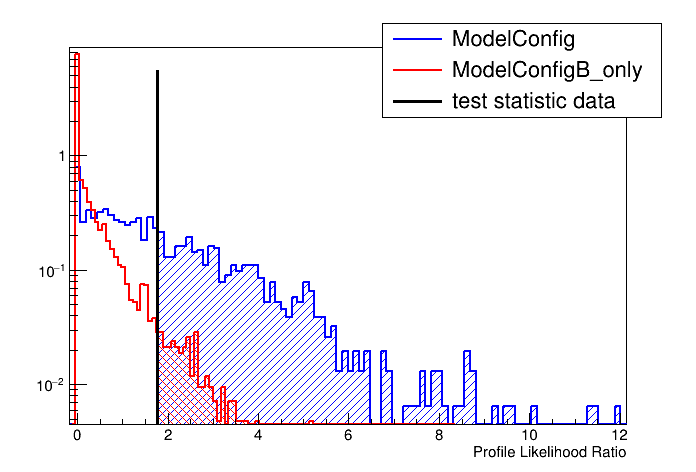

In [22]:
gROOT->GetListOfCanvases()->Draw()